# Model Definition test

In this notebook we try to train a model to predict traffic state.

In [1]:
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch
from torch import nn
import time
import pickle as pkl
import matplotlib.pyplot as plt
import os
from glob import glob, iglob

In [2]:
# generate training pair from tensors
def batch_data(states, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader

    Args:
        states:
        sequence_length: The sequence length of each batch
        batch_size: The size of each batch; the number of sequences in a batch

    Return:
        DataLoader with batched data
    """
    num_batches = len(states) // batch_size

    # only full batches
    states = states[: num_batches * batch_size]

    # TODO: Implement function
    features, targets = [], []

    for idx in range(0, (len(states) - sequence_length)):
        features.append(states[idx: idx + sequence_length])
        targets.append(states[idx + sequence_length])

    data = TensorDataset(torch.from_numpy(np.array(features)),
                         torch.from_numpy(np.array(targets)))

    data_loader = torch.utils.data.DataLoader(data, shuffle=False, batch_size=batch_size, num_workers=0)

    # return a dataloader
    return data_loader

In [3]:
train_dir = 'tensor_dataset/nn_test_15min/tensors'
valid_dir = 'tensor_dataset/nn_test_15min_val/tensors'

train_iter = iglob(train_dir + '/*')
valid_iter = iglob(valid_dir + '/*')

train_states = []
valid_states = []

for state in train_iter:
    state = torch.load(state).numpy()
    train_states.append(state)
    
for state in valid_iter:
    state = torch.load(state).numpy()
    valid_states.append(state)

train_states = np.array(train_states)
valid_states = np.array(valid_states)

train_states = train_states.reshape((len(train_states), -1))
valid_states = valid_states.reshape((len(valid_states), -1))
train_states = train_states.astype('float32')
valid_states = valid_states.astype('float32')

train_loader = batch_data(train_states, 12, 2)
valid_loader = batch_data(valid_states, 12, 2)

In [8]:
class StateRNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim=256, n_layers=2, drop_prob=0.5, lr=0.001):
        
        super().__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.lr = lr
        
        # define the LSTM
        self.lstm = nn.LSTM(input_size, self.hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(self.drop_prob)
        
        # define the final, fully-connected output layer
        self.fc = nn.Linear(hidden_dim, self.output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        
        # reshape to be batch_size first
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1]
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [9]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden, clip):
    """
    Forward and backward propagation on the neural network
    :param decoder: The PyTorch Module that holds the neural network
    :param decoder_optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """    
    # TODO: Implement Function

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in hidden])
        
    # zero accumulated gradients
    rnn.zero_grad()
    
    # print(f'input shape: {inp}, target shape: {target}')
    # get the output from the model
    output, h = rnn(inp, h)

    # perform backpropagation and optimization
    # calculate the loss and perform backprop
    loss = criterion(output, target)
    
    loss.backward()
    # 'clip_grad_norm' helps prevent the exploding gradient problem in RNNs / LSTMs
    nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), h

In [ ]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, clip=5, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset) // batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            # print(f'inputs shape: {inputs.shape} labels shape: {labels.shape}')
            # print(f'inputs dtype: {inputs[0][0][0].dtype} label shape: {labels[0][0].dtype}')
            inputs, labels = inputs.cuda(), labels.cuda()
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip)          
            # record loss
            batch_losses.append(loss)
            if (batch_i % show_every_n_batches == 0):
                # printing loss stats
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

In [10]:
def train_rnn(model, batch_size, optimizer, criterion, n_epochs,
              train_loader, valid_loader, clip=5, show_every_n_batches=100):
    '''
    Train a RNN model with the given hyperparameters.

    Args:
        model:
        batch_size:
        optimizer:
        criterion:
        n_epochs:
        train_loader:
        valid_loader:
        clip:
        show_every_batches:

    Returns:
        A trained model
    '''
    batch_losses = []

    model.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):

        hidden = model.init_hidden(batch_size)

        for batch_i, (inputs, labels) in enumerate(train_loader, 1):

            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset) // batch_size
            if(batch_i > n_batches):
                break

            # forward, back prop
            # print(f'inputs shape: {inputs.shape} labels shape: {labels.shape}')
            # print(f'inputs dtype: {inputs[0][0][0].dtype} label shape: {labels[0][0].dtype}')
            inputs, labels = inputs.cuda(), labels.cuda()

            loss, hidden = forward_back_prop(
                model, optimizer, criterion, inputs, labels, hidden, clip
            )

            # record loss
            batch_losses.append(loss)
            
            # print loss every show_every_n_batches batches
            # including validation loss
            if batch_i % show_every_n_batches == 0:
                # get validation loss
                val_h = model.init_hidden(batch_size)
                val_losses = []

                # switch to validation mode
                model.eval()

                for v_inputs, v_labels in valid_loader:

                    v_inputs, v_labels = v_inputs.cuda(), v_labels.cuda()

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    v_output, val_h = model(v_inputs, val_h)
                    val_loss = criterion(v_output, v_labels)

                    val_losses.append(val_loss.item())

                model.train()

                # printing loss stats
                print(f'Epoch: {epoch_i:>4}/{n_epochs:<4}  Loss: {np.average(batch_losses)}  Val Loss {np.mean(val_losses)}')
                batch_losses = []
                val_losses = []

    # returns a trained model
    return model

In [11]:
def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)


def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [13]:
# Data params
# Sequence Length
sequence_length = 12 # of words in a sequence
# Batch Size
batch_size = 2
# Gradient clip
clip = 5

In [14]:
# Training parameters
# Number of Epochs
num_epochs = 20
# Learning Rate
learning_rate = 0.001

# Output size
output_size = 69*69*3

# Hidden Dimension
hidden_dim = 512
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
senb = 1000

In [15]:
train_on_gpu = True

# create model and move to gpu if available
# def __init__(self, input_size, output_size, hidden_dim=256, n_layers=2, drop_prob=0.5, lr=0.001):
rnn = StateRNN(14283, 14283)
rnn = rnn.cuda()
    
# print the details of model
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader, show_every_n_batches=senb)

# saving the trained model
save_model(f'./trained_models/sl{sequence_length}-bs{batch_size}-lr{learning_rate}-hd{hidden_dim}-nl{n_layers}', trained_rnn)
print('Model Trained and Saved')

StateRNN(
  (lstm): LSTM(14283, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=256, out_features=14283, bias=True)
)
Training for 20 epoch(s)...
Epoch:    1/20    Loss: 0.5704490595720708
 Val Loss 0.46351306287473754
Epoch:    1/20    Loss: 0.5361692968700081
 Val Loss 0.5316795544816978
Epoch:    2/20    Loss: 0.47732206137073646
 Val Loss 0.40610086521593786
Epoch:    2/20    Loss: 0.48377808824181556
 Val Loss 0.41752248115375057
Epoch:    3/20    Loss: 0.4276056278760581
 Val Loss 0.40269187472222745
Epoch:    3/20    Loss: 0.45605226010642946
 Val Loss 0.422963288895454
Epoch:    4/20    Loss: 0.42413972480693574
 Val Loss 0.38509289833104965
Epoch:    4/20    Loss: 0.44726190896891055
 Val Loss 0.40608991398356664
Epoch:    5/20    Loss: 0.41287255661540767
 Val Loss 0.3924369770824889
Epoch:    5/20    Loss: 0.4387126291282475
 Val Loss 0.3838955447726283
Epoch:    6/20    Loss: 0.40602778038930665
 Val Loss 0.3961797638

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StateRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
ar = np.arange(len([1,2,3,4,5]))

In [17]:
ar

array([0, 1, 2, 3, 4])

In [18]:
from matplotlib import pyplot as plt

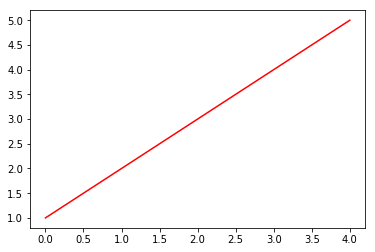

In [19]:
plt.plot(ar, [1,2,3,4,5], 'r-')